<a href="https://colab.research.google.com/github/SinghReena/MachineLearning/blob/master/Sai's_preliminary_solution_for_Bike_sharing_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing dataset


In [ ]:
#@title Install the 0.24 version of scikit-learn
!pip uninstall scikit-learn -y

!pip install -U scikit-learn


Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 6.1MB/s 


In [ ]:
#@title Imports
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import sklearn.linear_model as linear_module

In [ ]:
#@title Download the dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip

--2021-06-04 00:21:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  --.-KB/s    in 0.04s   

2021-06-04 00:21:04 (6.18 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]



In [ ]:
#@title
!unzip Bike-Sharing-Dataset.zip

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [ ]:
#@title The description of the data.
!cat Readme.txt

Bike Sharing Dataset

Hadi Fanaee-T

Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto
INESC Porto, Campus da FEUP
Rua Dr. Roberto Frias, 378
4200 - 465 Porto, Portugal


Background 

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of tra

In [ ]:
df = pd.read_csv('hour.csv')
df = df.set_index('instant', drop = True)
df

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90


In [ ]:
df.shape

(17379, 16)

We need to do limited preprocessing for this dataset. The numeric data has already been normalized.  We should do one-hot encoding for the categorical data.

## First visualization

First let us visualize to understand correlation.

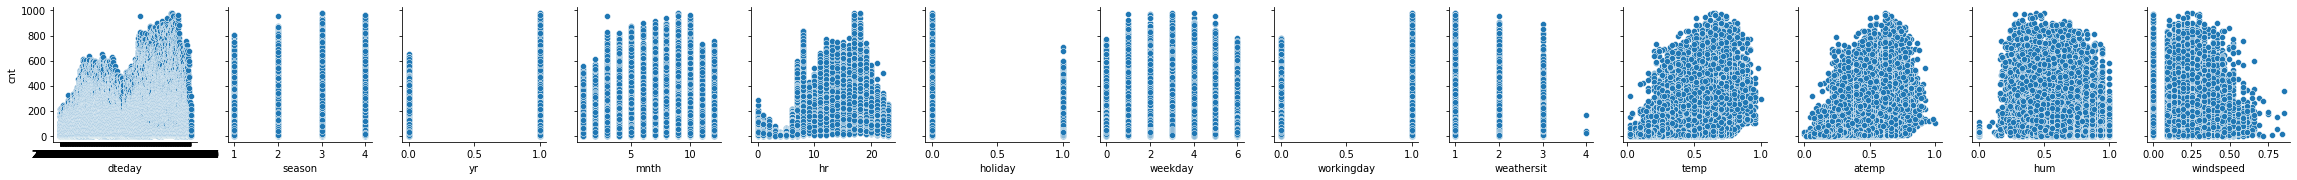

In [ ]:
sns.pairplot(df, y_vars="cnt", x_vars=['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'])

From first glance it looks like `month`, `hr`, `weekday` can explain most of the varation in `cnt`.

In [ ]:
#@title A function that does linear regression and returns the RSE error and r2 score.

from sklearn.model_selection import train_test_split
import sklearn.linear_model as linear_module
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import r2_score

def regress_and_get_scores(X, Y, model = linear_module.LinearRegression()):
  # test-train split
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

  # training
  reg = model.fit(X_train, y_train)

  # training error
  y_train_predict = reg.predict(X_train)
  regression_train_rse = math.sqrt(mean_squared_error(y_train_predict, y_train))

  # test error
  y_predict = reg.predict(X_test)
  regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))

  # r2_score
  r2 = r2_score(y_test, y_predict)
  return (regression_test_rse, r2)


## First variable `atemp`.

Intuitively this feels like a good predictor for the dataset.  But the pairplot does not seem to indicate a good relationship to the response variable.  We will try it as a simple test.

In [ ]:
rse, r2 = regress_and_get_scores(df[['holiday']], df[['cnt']])
print(rse, r2)

NameError: ignored

From the pairplot, it looks like `atemp` might not be a good predictor.  That is confirmed by the low r2 score. That is, only 16% of the variability of `cnt` has been explained by `atemp`.

## Selecting the three variables that seem to explain the variability the most.

From the pairplot `mnth`, `hr`, and `weekday` seem to explain the variability in the response variable the most.

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

ct = make_column_transformer(
    (ohe, ['mnth', 'hr', 'weekday']), 
    remainder= 'drop')
X = ct.fit_transform(df)
X[0:5]

<5x43 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

As expected there are 12 months + 24 hours + 7 days = 43 columns.

In [ ]:
pd.DataFrame.sparse.from_spmatrix(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
17375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
17376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
17377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
rse, r2 = regress_and_get_scores(X, df[['cnt']])
print(rse, r2)

120.24622193367615 0.5777730969170731


### Adding holiday

There is not much improvement in the RSE or r2 scores.

In [ ]:
ct = make_column_transformer(
    (ohe, ['mnth', 'hr', 'weekday']), 
    ("passthrough", ['holiday']), 
    remainder= 'drop')
X = ct.fit_transform(df)
X[0:5]

<5x44 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [ ]:
rse, r2 = regress_and_get_scores(X, df[['cnt']])
print(rse, r2)

120.24916965569304 0.5777523956796703


In [ ]:
ct = make_column_transformer(
    (ohe, ['mnth', 'hr', 'weekday', 'holiday']), 
    remainder= 'drop')
X = ct.fit_transform(df)
rse, r2 = regress_and_get_scores(X, df[['cnt']])
print(rse, r2)

120.24916962609052 0.5777523958875652


### Adding season

In [ ]:
ct = make_column_transformer(
    (ohe, ['mnth', 'hr', 'weekday', 'season']), 
    ("passthrough", ['holiday']), 
    remainder= 'drop')
X = ct.fit_transform(df)
rse, r2 = regress_and_get_scores(X, df[['cnt']])
print(rse, r2)

119.5050611140052 0.5829620102240053



### Adding year

There is a difference between the two years in the rental counts from the pair plot. So year is a likely useful feature.


In [ ]:
ct = make_column_transformer(
    (ohe, ['mnth', 'hr', 'weekday', 'season']), 
    ("passthrough", ['yr']), 
    remainder= 'drop')
X = ct.fit_transform(df)
rse, r2 = regress_and_get_scores(X, df[['cnt']])
print(rse, r2)

109.27838818399073 0.6512842337449076


### Add `weathersit`

In [ ]:
ct = make_column_transformer((ohe, ['mnth', 'hr', 'weekday', 'season', 'weathersit']), 
                             ("passthrough", ['yr']), 
                             remainder= 'drop')
X = ct.fit_transform(df)
rse, r2 = regress_and_get_scores(X, df[['cnt']])
print(rse, r2)

106.43765110336913 0.6691786073239003


### Add the other weather elements

In [ ]:
ct = make_column_transformer((ohe, ['mnth', 'hr', 'weekday', 'season', 'weathersit']), 
                             ("passthrough", ['yr', 'atemp', 'hum', 'windspeed']), 
                             remainder= 'drop')
X = ct.fit_transform(df)
rse, r2 = regress_and_get_scores(X, df[['cnt']])
print(rse, r2)

103.91280460029706 0.684687523890726


## Feature Selection --- Ridge, Lasso Forward and backward selection

In [ ]:
from sklearn.linear_model import RidgeCV

rse, r2 = regress_and_get_scores(X, df[['cnt']], RidgeCV(cv=5, alphas = [0.01,0.1, 0.5]))
print(rse, r2)

103.91442007793324 0.684677719820572


In [ ]:
from sklearn.linear_model import LassoCV

ct = make_column_transformer((ohe, ['mnth', 'hr', 'weekday', 'season', 'weathersit']), 
                             ("passthrough", ['yr', 'atemp', 'hum', 'windspeed']), 
                             remainder= 'drop')
X = ct.fit_transform(df)
rse, r2 = regress_and_get_scores(X, df[['cnt']], LassoCV(alphas=[0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 50, 100, 1000 ]))
print(rse, r2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


103.91248460586979 0.6846894658666016
